In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier #,Ridge,Lasso,ElasticNet
from sklearn.metrics import accuracy_score,recall_score,precision_score,roc_auc_score,f1_score,confusion_matrix,auc,roc_curve
from sklearn.model_selection import train_test_split,cross_val_score,KFold,RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import NearMiss
from sklearn.datasets import make_classification
import numpy as np
from collections import Counter

Opening our DataFrame

In [2]:
df = pd.read_csv('../../data/raw/creditcard.csv')

In [3]:
df.shape

(284807, 31)

Let's check the overall info of our DataFrame

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

Let's drop KidneyAilments and HeartAilments that are full null column values, and since we do not have any other table to join then we can drop Id

In [5]:
df.describe(include='all')

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


We can see below that it has been dropped

In [6]:
df.sample(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
95551,65367.0,-0.152657,0.882853,1.058953,0.649471,0.372797,-0.068280,0.548705,0.108437,-0.678521,...,0.099014,0.226457,-0.307893,-0.376285,0.185929,-0.238955,0.047123,0.015334,5.95,0
159630,112740.0,-0.700592,0.715835,1.090248,-1.229295,0.791813,0.351174,0.747971,-1.298331,1.185904,...,0.298009,-0.889054,0.085897,0.040025,-0.806895,0.098691,-0.083455,-0.358223,24.99,0
89124,62437.0,1.383927,-0.739020,0.766444,-0.729641,-1.320468,-0.456845,-1.043506,-0.015599,-0.306915,...,0.352291,0.928037,-0.171153,-0.081326,0.475612,-0.018298,0.031982,0.022213,24.99,0


We can check the overall statistics from our dataframe

In [7]:
object_cols = df.select_dtypes(include=['object']).columns

<b> Pipeline Team </b> You should create a function that converts all strings to uppercase

In [8]:
df[object_cols] = df[object_cols].apply(lambda x: x.str.upper())

<b> Pipeline Team </b> Example of pipeline function

In [9]:
def drop_high_nulls_col(df):
    # Grouped median calculation for filling missing values
    
    for cols in df.columns:
        if (df[cols].notnull().sum() / df.shape[0]) < 0.4:
            df.drop(columns=[cols], inplace=True)
            
    return df

In [10]:
df = drop_high_nulls_col(df)

Let's understand FacilityId better, because if there is lot's of facility id's then we can also drop this column

In [11]:
df.shape[0]

284807

### Feature Engineering

In [12]:
df.rename(columns={'Class':'TARGET'},inplace = True)

In [13]:
X_col = df.drop(columns = 'TARGET').columns
y_col = ['TARGET']

We are doing a 80-20 Train,Test split we will be locking the random_state as 37 so our results are easy to produce again

In [14]:
group_cols = []

In [15]:
X_train,X_test,y_train,y_test = train_test_split(df[X_col],df[y_col],test_size=0.3, random_state=0)

In [16]:
#X_train.to_parquet('../data/processed/X_train.parquet',index=False)
#X_test.to_parquet('../data/processed/X_test.parquet',index=False)
#y_train.to_parquet('../data/processed/y_train.parquet',index=False)
#y_test.to_parquet('../data/processed/y_test.parquet',index=False)

Now to start feature engineering let's check our null values one more time

<b> Pipeline Team </b> Example of pipeline function

In [17]:
def null_dict(df,grouped_cols):
    imputation_dict = {}
    # Calculate the sum of null values for each column
    null_sum = df.isnull().sum()

    # Filter columns where the sum of null values is greater than 0
    columns_with_nulls = null_sum[null_sum > 0].index

    # Select only the columns from the original DataFrame that have more than 0 null values
    null_cols = df.loc[:, columns_with_nulls].columns
    for col in null_cols:
        if (df[col].dtypes == 'int64') | (df[col].dtypes == 'float64'):
            imputation_dict.update({col : df.groupby(grouped_cols)[col].median().to_dict()})
        elif (df[col].dtypes == 'O'):
            imputation_dict.update({col : df.groupby(grouped_cols)[col].agg(pd.Series.mode).to_dict()})
                
    return imputation_dict

Lets go ahead and imput the values on the DF

In [18]:
imput_dict = null_dict(X_train,group_cols)

<b> Pipeline Team </b> Example of pipeline function

In [19]:
def fillnulls(data,grouped_cols,imput_dict):
    imputation_dict = imput_dict
    
    col_x,col_y,col_z =grouped_cols
    
    for col in imputation_dict:
        for val in imputation_dict[col]:
            val_x,val_y,val_z = val
            data.loc[(data[col_x] == val_x) & (data[col_z] == val_z) & (data[col_z] == val_z),col] = imputation_dict[col][val]
    return data

In [20]:
#X_train = fillnulls(X_train,group_cols,imput_dict)
#X_test = fillnulls(X_test,group_cols,imput_dict)

<b> Pipeline Team </b> You should create a function to do one hotting and one to convert it back

In [21]:
object_cols = df.select_dtypes(include=['object']).columns

In [22]:
oneh = OneHotEncoder(sparse_output=False)
oneh.fit(X_train[object_cols])

OneHotEncoder(sparse_output=False)

In [23]:
col_names = oneh.get_feature_names_out()

In [24]:
#X_train_dummies = pd.DataFrame(oneh.transform(X_train[object_cols]),columns = col_names)
#X_train_dummies.index = X_train.index
#X_train = pd.merge(X_train,X_train_dummies,left_index=True,right_index=True)
#
#X_test_dummies = pd.DataFrame(oneh.transform(X_test[object_cols]),columns = col_names)
#X_test_dummies.index = X_test.index
#X_test = pd.merge(X_test,X_test_dummies,left_index=True,right_index=True)

In [25]:
X_train.sample(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
233812,147713.0,1.383996,-1.902264,-3.050818,-0.242012,-0.131733,-1.114415,0.993349,-0.578045,-1.249507,...,0.212073,0.172327,0.038950,-0.540079,-0.429364,0.331477,0.986202,-0.218509,-0.031960,454.96
217779,141030.0,0.089470,0.353230,-1.686257,-1.976789,1.308581,-0.835942,2.102508,-0.469571,-0.578467,...,0.139352,0.398588,1.060708,-0.287286,-0.976356,0.522228,1.041701,-0.120292,-0.017186,131.00
185906,126872.0,-1.142849,-0.032864,0.953088,2.991481,1.523578,0.267848,0.917333,-0.192484,-1.004650,...,-0.464774,-0.605790,-1.350487,0.925407,0.449216,-0.429580,-0.694112,-0.308517,-0.165711,83.23


All that's left is to drop Gender

In [26]:
#X_train.drop(columns = object_cols,inplace = True)
#X_test.drop(columns = object_cols,inplace = True)

We will now transform balance this data

<b> Pipeline Team </b> Create a function that combines the three techniques and outpus X_train, y_train midsampled, check below for what you should expect

In [27]:
y_train.groupby(['TARGET']).size()

TARGET
0    199019
1       345
dtype: int64

In [28]:
def oversample_with_adasyn(X, y, target_minority_samples=100000):
    """
    Oversample the minority class using ADASYN until the minority class reaches the target_minority_samples.
    
    Parameters:
    - X: Feature matrix
    - y: Target vector
    - target_minority_samples: Desired number of samples for the minority class after oversampling
    
    Returns:
    - X_resampled, y_resampled: Feature matrix and target vector after resampling
    """
    # Identify minority class
    classes, counts = np.unique(y, return_counts=True)
    minority_class = classes[np.argmin(counts)]
    current_minority_samples = counts[np.argmin(counts)]

    # Calculate how many new samples we need to generate for the minority class
    if current_minority_samples >= target_minority_samples:
        raise ValueError("The minority class already has more or equal samples than the target_minority_samples.")
    
    n_samples_to_generate = target_minority_samples - current_minority_samples

    # Set the sampling strategy for ADASYN
    # This will tell ADASYN to generate the specified number of samples for the minority class
    sampling_strategy = {minority_class: n_samples_to_generate}

    # Create the ADASYN instance and fit it to the data
    adasyn = ADASYN(sampling_strategy=sampling_strategy, n_neighbors=5, random_state=42)
    X_resampled, y_resampled = adasyn.fit_resample(X, y)

    return X_resampled, y_resampled

In [29]:
def undersample_with_nearmiss(X, y):
    """
    Undersample the majority class using NearMiss until it is balanced with the minority class.
    
    Parameters:
    - X: Feature matrix
    - y: Target vector
    
    Returns:
    - X_resampled, y_resampled: Feature matrix and target vector after resampling
    """
    # Identify majority and minority classes
    classes, counts = np.unique(y, return_counts=True)
    minority_class_count = min(counts)
    
    # Set the sampling strategy for NearMiss
    # This will balance the majority class with the minority class
    nm = NearMiss()
    
    # Perform the undersampling
    X_resampled, y_resampled = nm.fit_resample(X, y)
    
    # Check if undersampling was successful
    if len(np.unique(y_resampled, return_counts=True)[1]) != 2 or np.unique(y_resampled, return_counts=True)[1][0] != minority_class_count:
        raise ValueError("NearMiss did not undersample correctly.")
    
    return X_resampled, y_resampled

In [30]:
X_resampled,y_resampled = oversample_with_adasyn(X_train,y_train)

In [31]:
X_train,y_train = undersample_with_nearmiss(X_resampled,y_resampled)

In [32]:
y_train.groupby(['TARGET']).size()

TARGET
0    99728
1    99728
dtype: int64

In [33]:
#X_train.to_parquet('../data/processed/X_train_engineered.parquet',index=False)
#X_test.to_parquet('../data/processed/X_test_engineered.parquet',index=False)
#y_train.to_parquet('../data/processed/y_train_engineered.parquet',index=False)
#y_test.to_parquet('../data/processed/y_test_engineered.parquet',index=False)

Scaling

<b> Pipeline Team </b> Create a function to scale and one to de-scale variables.

In [34]:
scaler = StandardScaler()

In [35]:
scaler.fit(X_train)

StandardScaler()

In [36]:
X_train_scaled = scaler.transform(X_train)
X_train = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)

In [37]:
X_test_scaled = scaler.transform(X_test)
X_test = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)

Let's try RFE

In [38]:
from sklearn.feature_selection import RFE

In [39]:
# Starting Linear Regression
logr = LogisticRegression(max_iter = 1000)
rfe = RFE(estimator=logr, n_features_to_select=15)
rfe.fit(X_train, y_train)

#Fitting Linear Regression
logr.fit(X_train,y_train)

LogisticRegression(max_iter=1000)

In [40]:
cols = rfe.get_feature_names_out()

### Machine Learning

M.L. Team:
- You should work on not overfitting and having a feasible model. <b> You can only use Logistic Regression/Ridge/Lasso </b>
- Think correctly on the error metric, remember that we want to have a model that predicts very well FRAUD so we can penalize False Positives
- Use my overfitted scores and try to beat them, and it is as simple as having a feasible model, after that you start to improve.

<b>LinearRegression<b>

In [41]:
# Starting Linear Regression
logr = LogisticRegression(max_iter = 10000)

#Fitting Linear Regression
logr.fit(X_train[cols],y_train)

#Printing errors
print('Accuracy of training is '+ str(accuracy_score(y_train,logr.predict(X_train[cols]))))
print('Precision of training is '+ str(precision_score(y_train,logr.predict(X_train[cols]))))
print('Recall of training is '+ str(recall_score(y_train,logr.predict(X_train[cols]))))
print('F1 of training is '+ str(f1_score(y_train,logr.predict(X_train[cols]))))
print('ROC AUC of training is '+ str(roc_auc_score(y_train,logr.predict(X_train[cols]))))
print()
print('Accuracy of test is '+ str(accuracy_score(y_test,logr.predict(X_test[cols]))))
print('Precision of test is '+ str(precision_score(y_test,logr.predict(X_test[cols]))))
print('Recall of test is '+ str(recall_score(y_test,logr.predict(X_test[cols]))))
print('F1 of test is '+ str(f1_score(y_test,logr.predict(X_test[cols]))))
print('ROC AUC of test is '+ str(roc_auc_score(y_test,logr.predict(X_test[cols]))))

Accuracy of training is 0.9816250200545483
Precision of training is 0.9910643997096441
Recall of training is 0.9720138777474732
F1 of training is 0.9814467016639752
ROC AUC of training is 0.9816250200545483

Accuracy of test is 0.9709630982058214
Precision of test is 0.05184331797235023
Recall of test is 0.9183673469387755
F1 of test is 0.09814612868047982
ROC AUC of test is 0.9447105446005076


In [42]:
predicted_proba = logr.predict_proba(X_test[cols])

In [43]:
predicted = logr.predict(X_test[cols])

In [44]:
y_probs = predicted_proba[:, 1]

In [45]:
def find_best_threshold(y_true, y_probs):
    best_threshold = 0
    best_score = 0

    for threshold in np.arange(0.001, 1, 0.001):
        # Convert probabilities to binary predictions based on the current threshold
        y_pred = (y_probs >= threshold).astype(int)
        
        # Calculate the metric of interest, e.g., F1 score
        score = f1_score(y_true, y_pred)
        
        if score > best_score:
            best_score = score
            best_threshold = threshold

    return best_threshold, best_score

best_threshold, best_score = find_best_threshold(y_test['TARGET'], y_probs)

print(f"Best Threshold: {best_threshold}")
print(f"Best F1 Score: {best_score}")

Best Threshold: 0.999
Best F1 Score: 0.3872


Ridge

In [46]:
# Starting Ridge
logr = RidgeClassifier(alpha=2)

#Fitting
logr.fit(X_train,y_train)

#Printing errors
print('Accuracy of training is '+ str(accuracy_score(y_train,logr.predict(X_train))))
print('Precision of training is '+ str(precision_score(y_train,logr.predict(X_train))))
print('Recall of training is '+ str(recall_score(y_train,logr.predict(X_train))))
print('F1 of training is '+ str(f1_score(y_train,logr.predict(X_train))))
print('ROC AUC of training is '+ str(roc_auc_score(y_train,logr.predict(X_train))))
print()
print('Accuracy of test is '+ str(accuracy_score(y_test,logr.predict(X_test))))
print('Precision of test is '+ str(precision_score(y_test,logr.predict(X_test))))
print('Recall of test is '+ str(recall_score(y_test,logr.predict(X_test))))
print('F1 of test is '+ str(f1_score(y_test,logr.predict(X_test))))
print('ROC AUC of test is '+ str(roc_auc_score(y_test,logr.predict(X_test))))

Accuracy of training is 0.9398413685223809
Precision of training is 0.9914844984257527
Recall of training is 0.8873034654259586
F1 of training is 0.9365055006693936
ROC AUC of training is 0.9398413685223809

Accuracy of test is 0.9689032454384795
Precision of test is 0.04462989840348331
Recall of test is 0.8367346938775511
F1 of test is 0.08473992421632794
ROC AUC of test is 0.9029328599757293


<b>XGBoost<b>

In [47]:
#X_train.columns

In [48]:
# Starting XGBoost
logr = XGBClassifier(n_estimators = 1000,learning_rate = 0.001,eval_metric='aucpr')

#Fitting
logr.fit(X_train[cols],y_train)

#Printing errors
print('Accuracy of training is '+ str(accuracy_score(y_train,logr.predict(X_train[cols]))))
print('Precision of training is '+ str(precision_score(y_train,logr.predict(X_train[cols]))))
print('Recall of training is '+ str(recall_score(y_train,logr.predict(X_train[cols]))))
print('F1 of training is '+ str(f1_score(y_train,logr.predict(X_train[cols]))))
print('ROC AUC of training is '+ str(roc_auc_score(y_train,logr.predict(X_train[cols]))))
print()
print('Accuracy of test is '+ str(accuracy_score(y_test,logr.predict(X_test[cols]))))
print('Precision of test is '+ str(precision_score(y_test,logr.predict(X_test[cols]))))
print('Recall of test is '+ str(recall_score(y_test,logr.predict(X_test[cols]))))
print('F1 of test is '+ str(f1_score(y_test,logr.predict(X_test[cols]))))
print('ROC AUC of test is '+ str(roc_auc_score(y_test,logr.predict(X_test[cols]))))

Accuracy of training is 0.9852799614952671
Precision of training is 0.9931724615823585
Recall of training is 0.9772781966950105
F1 of training is 0.9851612251086627
ROC AUC of training is 0.9852799614952672

Accuracy of test is 0.9870908090773967
Precision of test is 0.1069078947368421
Recall of test is 0.8843537414965986
F1 of test is 0.19075568598679385
ROC AUC of test is 0.9358108043442476


<b>LightGBM<b>

In [49]:
# Starting XGBoost
logr = LGBMClassifier(n_estimators = 1000,learning_rate = 0.01)

#Fitting
logr.fit(X_train[cols],y_train)

#Printing errors
print('Accuracy of training is '+ str(accuracy_score(y_train,logr.predict(X_train[cols]))))
print('Precision of training is '+ str(precision_score(y_train,logr.predict(X_train[cols]))))
print('Recall of training is '+ str(recall_score(y_train,logr.predict(X_train[cols]))))
print('F1 of training is '+ str(f1_score(y_train,logr.predict(X_train[cols]))))
print('ROC AUC of training is '+ str(roc_auc_score(y_train,logr.predict(X_train[cols]))))
print()
print('Accuracy of test is '+ str(accuracy_score(y_test,logr.predict(X_test[cols]))))
print('Precision of test is '+ str(precision_score(y_test,logr.predict(X_test[cols]))))
print('Recall of test is '+ str(recall_score(y_test,logr.predict(X_test[cols]))))
print('F1 of test is '+ str(f1_score(y_test,logr.predict(X_test[cols]))))
print('ROC AUC of test is '+ str(roc_auc_score(y_test,logr.predict(X_test[cols]))))

[LightGBM] [Info] Number of positive: 99728, number of negative: 99728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005454 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 199456, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Accuracy of training is 0.9996991817744264
Precision of training is 0.9994187444880943
Recall of training is 0.9999799454516284
F1 of training is 0.9996992662095513
ROC AUC of training is 0.9996991817744264

Accuracy of test is 0.9968282948866496
Precision of test is 0.3333333333333333
Recall of test is 0.8435374149659864
F1 of test is 0.47784200385356457
ROC AUC of test is 0.9203149464625469


In [50]:
# Starting XGBoost
logr = RandomForestClassifier()

#Fitting
logr.fit(X_train[cols],y_train)

#Printing errors
print('Accuracy of training is '+ str(accuracy_score(y_train,logr.predict(X_train[cols]))))
print('Precision of training is '+ str(precision_score(y_train,logr.predict(X_train[cols]))))
print('Recall of training is '+ str(recall_score(y_train,logr.predict(X_train[cols]))))
print('F1 of training is '+ str(f1_score(y_train,logr.predict(X_train[cols]))))
print('ROC AUC of training is '+ str(roc_auc_score(y_train,logr.predict(X_train[cols]))))
print()
print('Accuracy of test is '+ str(accuracy_score(y_test,logr.predict(X_test[cols]))))
print('Precision of test is '+ str(precision_score(y_test,logr.predict(X_test[cols]))))
print('Recall of test is '+ str(recall_score(y_test,logr.predict(X_test[cols]))))
print('F1 of test is '+ str(f1_score(y_test,logr.predict(X_test[cols]))))
print('ROC AUC of test is '+ str(roc_auc_score(y_test,logr.predict(X_test[cols]))))

Accuracy of training is 1.0
Precision of training is 1.0
Recall of training is 1.0
F1 of training is 1.0
ROC AUC of training is 1.0

Accuracy of test is 0.9992860737567735
Precision of test is 0.76875
Recall of test is 0.8367346938775511
F1 of test is 0.8013029315960912
ROC AUC of test is 0.9181504551736283


Let's try switching the probability ranges

In [51]:
cm = confusion_matrix(y_test,logr.predict(X_test[cols]))

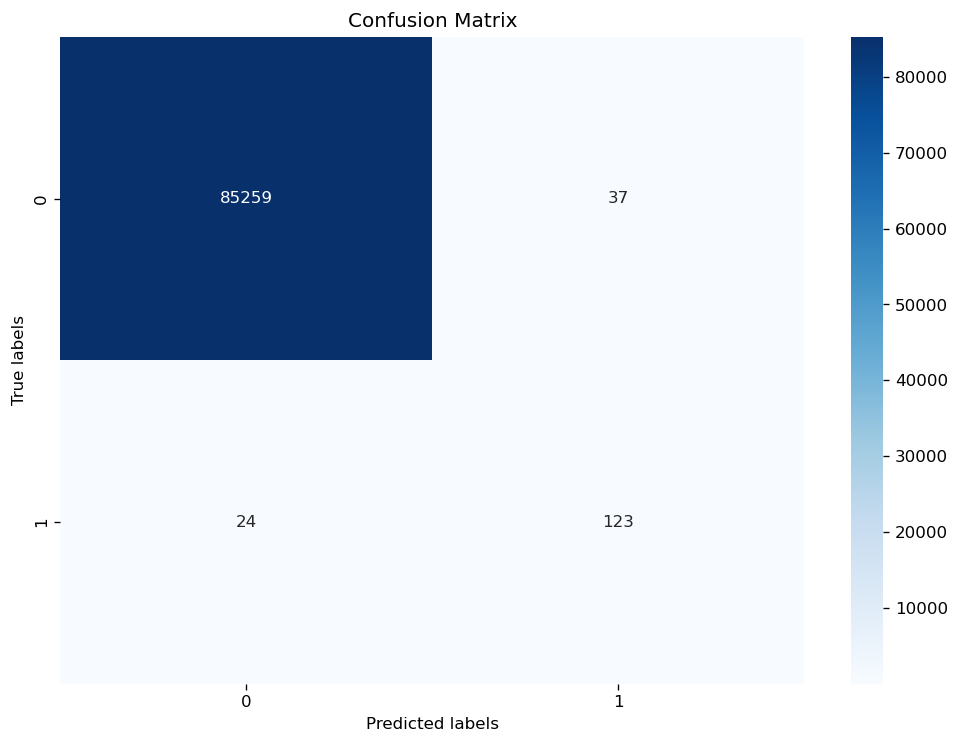

In [52]:
# Plotting the confusion matrix
plt.figure(figsize=(10,7),dpi=120)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [53]:
y_prob = logr.predict_proba(X_test[cols])[:, 1]

In [54]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

In [63]:
y_test['predicted_probabilities'] = y_prob
y_test['predicted_class'] = logr.predict(X_test[cols])

In [67]:
y_test.to_csv('../../data/processed/model_performance.csv',index=False)

In [55]:
roc_auc = auc(fpr, tpr)

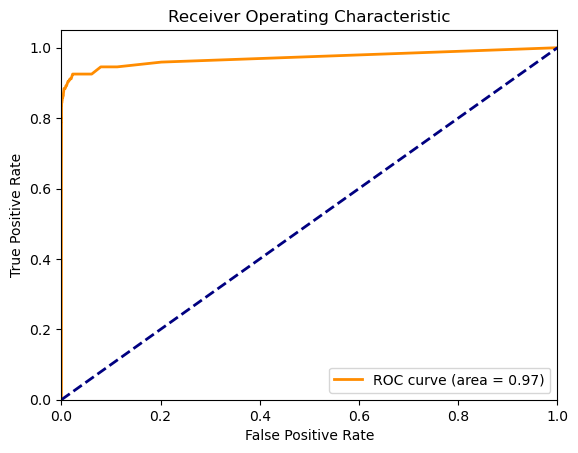

In [56]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [57]:
param_grid = {
    'num_leaves': [31, 50, 70, 100], #Number of leaves parameter        
    'max_depth': [-1, 5, 10, 20],  # Max depth parameter
    'learning_rate': [0.0001,0.001, 0.01, 0.1], #Learning Rate Parameter
    'n_estimators': [500,1000,1500,2000], #Number of fitted trees 
    'min_split_gain': [0.0, 0.1, 0.2], #Number related to minimum split gain      
    'min_child_weight': [0.001, 0.01, 0.1], #Number related to minimum child weight  
    'subsample': [0.8, 0.9, 1.0], #Subsample number           
    'colsample_bytree': [0.8, 0.9, 1.0] #number of colsample bytree
}

In [ ]:
xgb_random = LGBMClassifier(random_state = 42)
# Setup RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_random, 
    param_distributions=param_grid, 
    n_iter=100,
    cv=5, 
    verbose=1, 
    random_state=42, 
    n_jobs=-1  # Use all available cores
)

# Perform the random search
random_search.fit(X_train[cols], y_train)

# Best parameters and best score
print("Best parameters found: ", random_search.best_params_)
print("Best score found: ", random_search.best_score_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [ ]:
print('Accuracy of training is '+ str(accuracy_score(y_train,random_search.predict(X_train[cols]))))
print('Precision of training is '+ str(precision_score(y_train,random_search.predict(X_train[cols]))))
print('Recall of training is '+ str(recall_score(y_train,random_search.predict(X_train[cols]))))
print('F1 of training is '+ str(f1_score(y_train,random_search.predict(X_train[cols]))))
print('ROC AUC of training is '+ str(roc_auc_score(y_train,random_search.predict(X_train[cols]))))
print()
print('Accuracy of test is '+ str(accuracy_score(y_test,random_search.predict(X_test[cols]))))
print('Precision of test is '+ str(precision_score(y_test,random_search.predict(X_test[cols]))))
print('Recall of test is '+ str(recall_score(y_test,random_search.predict(X_test[cols]))))
print('F1 of test is '+ str(f1_score(y_test,random_search.predict(X_test[cols]))))
print('ROC AUC of test is '+ str(roc_auc_score(y_test,random_search.predict(X_test[cols]))))